In [1]:
import pandas as pd
import os
from glob import glob
from matplotlib import pylab as plt
import seaborn.apionly as sns
%matplotlib inline
import json
from collections import Counter
import sys
sys.path.append('../')
import src.utils as utils
import tqdm
import numpy as np

In [2]:
fn_config = '../config/contingency_belviq.json'
config = json.load(open(fn_config))
for key, values in config.items():
    values = {v.upper() for v in values}
    config[key] = values

In [32]:
config_name = 'belviq'
fn_in = '/Users/boris/devel/faers/data/interim/contingency/belviq.csv'
dir_out = '/Users/boris/devel/faers/data/processed/reports/belviq'
alpha = 0.95

In [70]:
matrix

Contingency matrix
                       q        n
exposure outcome                 
False    False    2017q3  4882922
         True     2017q3   158643
True     False    2017q3     2436
         True     2017q3       39

NameError: name 'curr' is not defined

In [72]:
%run -i ../src/utils.py
contingency_matrices = pd.read_csv(fn_in)
gr = contingency_matrices.groupby('q')
tbl_report = []
for q, t in gr:
    matrix = ContingencyMatrix(t)
    ror = matrix.ror(alpha=alpha)
    curr = {
        'q': q,
        'ROR': ror[0],
        'ROR_lower': ror[1][0],
        'ROR_upper': ror[1][1]
    }
    for n, label in zip(matrix.ror_components(), ['True_True', 'True_False', 'False_True', 'False_False']):
        curr[label] = n
    tbl_report.append(curr)
tbl_report = pd.DataFrame.from_records(tbl_report)
tbl_report

../src/utils.py:119: RuntimeWarning: invalid value encountered in long_scalars
  ror = (a * d) / (b * c)
../src/utils.py:122: RuntimeWarning: divide by zero encountered in log
  ln_ror = np.log(ror)
../src/utils.py:125: RuntimeWarning: invalid value encountered in add
  ci_ln_ror = ln_ror + interval


,False_False,False_True,ROR,ROR_lower,ROR_upper,True_False,True_True,q
0,215931,7247,NaN,NaN,NaN,0,0,2013q1
1,380873,13652,NaN,NaN,NaN,0,0,2013q2
2,559401,20647,0.000000,0.000000,NaN,2,0,2013q3
3,785528,26568,0.000000,0.000000,NaN,30,0,2013q4
4,1036300,33997,0.000000,0.000000,NaN,67,0,2014q1
5,1232260,58739,0.000000,0.000000,NaN,141,0,2014q2
6,1427060,69225,0.047830,0.006722,0.340327,431,1,2014q3
7,1618671,77702,0.062809,0.020222,0.195082,995,3,2014q4
8,1888779,93574,0.092946,0.041679,0.207274,1303,6,2015q1
9,2160120,100189,0.137503,0.073836,0.256069,1568,10,2015q2


In [73]:
tbl_report.sort_values('q', inplace=True)

In [74]:
tbl_report['l10_ROR'] = np.log10(tbl_report.ROR)
tbl_report['l10_ROR_upper'] = np.log10(tbl_report.ROR_upper)
tbl_report['l10_ROR_lower'] = np.log10(tbl_report.ROR_lower)

../src/utils.py:1: RuntimeWarning: divide by zero encountered in log10
  import json
../src/utils.py:3: RuntimeWarning: divide by zero encountered in log10
  from collections import namedtuple


In [97]:
figsize = (8, 4.5); dpi = 120
def plot_ror(tbl_report, ax_ror=None):
    if ax_ror is None:
        fig_ror, ax_ror = plt.subplots(figsize=figsize, dpi=dpi)

    q_first = tbl_report.q.min()
    q_last = tbl_report.q.max()
    quarters = list(sorted(tbl_report.q.unique())) # we assume no Q is missing
    quarters
    x = list(range(len(quarters)))

    ax_ror.plot(x, tbl_report.l10_ROR, '-o', color='C0', zorder=99)
    ax_ror.fill_between(x, tbl_report.l10_ROR_lower, tbl_report.l10_ROR_upper, color='C0', alpha=0.3)
    ax_ror.set_ylim(-2.1, 2.1)
    tkx = [-1, 0, 1]
    ax_ror.set_yticks(tkx)
    ax_ror.set_yticklabels([f'$\\times {10**t}$' for t in tkx])
    sns.despine(ax=ax_ror)
    ax_ror.spines['bottom'].set_position('zero')
    tkx = []
    lbls = []
    for i, q in enumerate(quarters):
        if q.endswith('1'):
            tkx.append(i)
            lbls.append(q.split('q')[0])

    ax_ror.set_xticks(tkx)
    ax_ror.set_xticklabels(lbls)
    ax_ror.text(
        x=max(x) + 0.15,
        y=tbl_report.l10_ROR.iloc[-1],
        s=f'${tbl_report.ROR.iloc[-1]:.2f}$', 
        ha='left', va='center', color='gray'
    )

    ax_ror.text(
        x=max(x) + 0.1,
        y=tbl_report.l10_ROR_lower.iloc[-1],
        s=f'${tbl_report.ROR_lower.iloc[-1]:.2f}$', 
        ha='left', va='top', size='small', color='gray'
    )

    ax_ror.text(
        x=max(x) + 0.1,
        y=tbl_report.l10_ROR_upper.iloc[-1],
        s=f'${tbl_report.ROR_upper.iloc[-1]:.2f}$', 
        ha='left', va='bottom', size='small', color='gray'
    )
    return ax_ror



In [98]:
def plot_incidence(tbl_report, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    q_first = tbl_report.q.min()
    q_last = tbl_report.q.max()
    quarters = list(sorted(tbl_report.q.unique())) # we assume no Q is missing
    quarters
    x = list(range(len(quarters)))

    x = list(range(len(quarters)))
    reports = tbl_report.True_True + tbl_report.True_False
    reports = reports.diff()
    tbl_report['reports'] = reports
    ax.plot(x, reports, 'o-')

    tkx = []
    lbls = []
    for i, q in enumerate(quarters):
        if q.endswith('1'):
            tkx.append(i)
            lbls.append(q.split('q')[0])

    ax.set_xticks(tkx)
    ax.set_xticklabels(lbls)
    sns.despine(ax=ax)
    ax.set_yticks([0, 250, 500])
    return ax

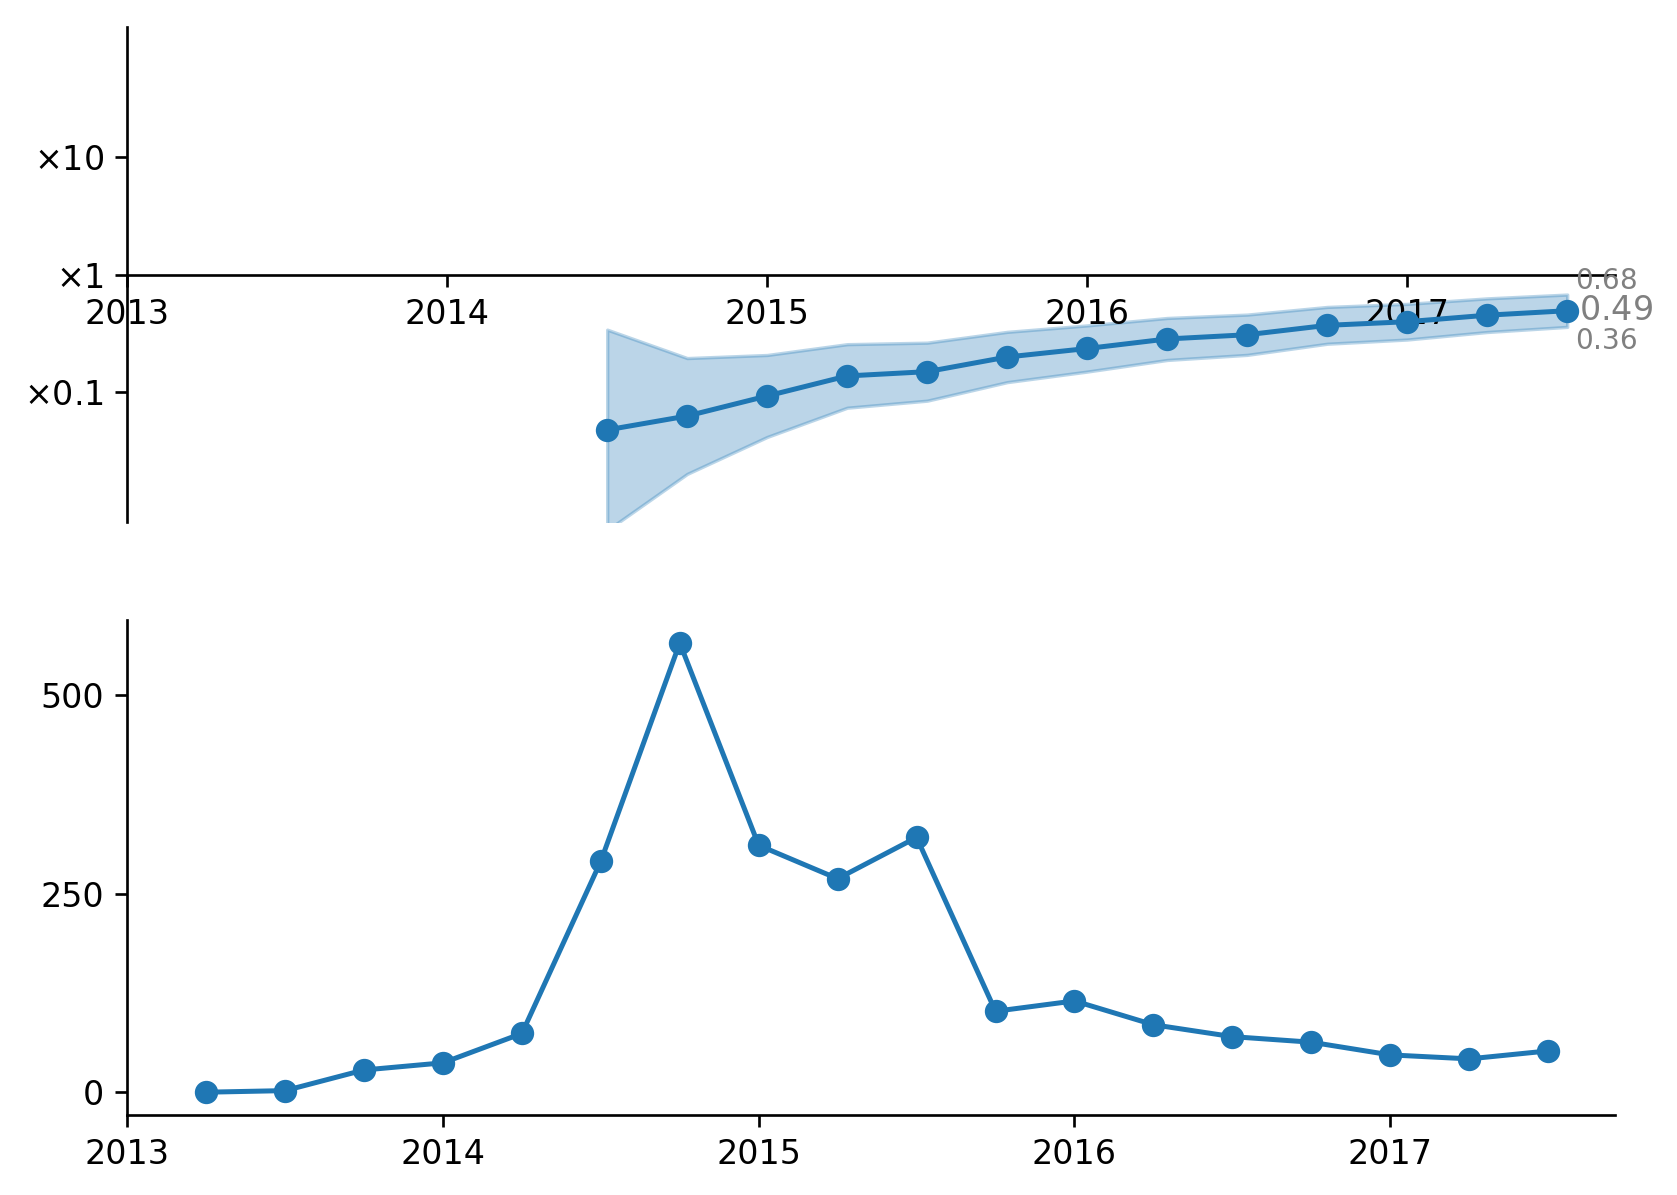

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), dpi=240)
plot_ror(tbl_report, axes[0])
plot_incidence(tbl_report, ax=axes[1])

In [ ]:
fig, 

In [66]:
tbl_report

,ROR,ROR_lower,ROR_upper,q,l10_ROR,l10_ROR_upper,l10_ROR_lower
0,NaN,NaN,NaN,2013q1,NaN,NaN,NaN
1,NaN,NaN,NaN,2013q2,NaN,NaN,NaN
2,0.000000,0.000000,NaN,2013q3,-inf,NaN,-inf
3,0.000000,0.000000,NaN,2013q4,-inf,NaN,-inf
4,0.000000,0.000000,NaN,2014q1,-inf,NaN,-inf
5,0.000000,0.000000,NaN,2014q2,-inf,NaN,-inf
6,0.047830,0.006722,0.340327,2014q3,-1.320298,-0.468103,-2.172493
7,0.062809,0.020222,0.195082,2014q4,-1.201975,-0.709784,-1.694167
8,0.092946,0.041679,0.207274,2015q1,-1.031767,-0.683455,-1.380080
9,0.137503,0.073836,0.256069,2015q2,-0.861688,-0.591644,-1.131733


In [31]:
quarter_first = utils.Quarter('2013q1')
quarter_last = utils.Quarter('2014q2')
caseids_merged = set()
caseids_drug = set()
caseids_reac = set()
data = []
total_rows = 0
n_quarters = len(list(utils.generate_quarters(quarter_first, quarter_last)))
for q in tqdm.tqdm_notebook(utils.generate_quarters(quarter_first, quarter_last), total=n_quarters):
    fn_drug = f'../data/interim/deduplicated/drug{q}.csv.zip'
    fn_reaction = f'../data/interim/deduplicated/reac{q}.csv.zip'
    df_drug = pd.read_csv(
        fn_drug, dtype=str
    )[
        ['primaryid', 'caseid', 'drugname']
    ].dropna(
    ).drop_duplicates(subset=['primaryid', 'drugname'])
    df_reac = pd.read_csv(
        fn_reaction, dtype=str
    )[
        ['primaryid', 'caseid', 'pt']
    ].dropna(
    ).drop_duplicates(
    )
    df_merged = df_drug.merge(df_reac, on='caseid')
    df_merged['q'] = str(q)
    df_merged['pt'] = df_merged.pt.str.upper()
    data.append(df_merged)
    total_rows += len(df_merged)

data = pd.concat(data).set_index('caseid', drop=False)
print(f'Analyzing {len(data):,d} rows')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Analyzing 13,770,113 rows


In [32]:
def classify_case(df_case):
    return {
        'is_drug': df_case.drugname.isin(config['drug']).any(),
        'is_reaction': df_case.pt.isin(config['reaction']).any(),
        'q': df_case['q'].iloc[0]
    }

In [33]:
from multiprocessing import Pool, cpu_count
import time

In [34]:
gr = data.groupby(
    data.index
)
n_groups = len(gr)
print(f'Will analyze {n_groups:,d} groups')

Will analyze 1,070,364 groups


In [50]:
data.head()

,primaryid_x,caseid,drugname,primaryid_y,pt,q
caseid,,,,,,
3037529,30375293,3037529,AVONEX,30375293,AMENORRHOEA,2013q1
3037529,30375293,3037529,AVONEX,30375293,ASTHENIA,2013q1
3037529,30375293,3037529,AVONEX,30375293,BLADDER DISORDER,2013q1
3037529,30375293,3037529,AVONEX,30375293,BLOOD PRESSURE INCREASED,2013q1
3037529,30375293,3037529,AVONEX,30375293,DEHYDRATION,2013q1


In [56]:
np.repeat(config['drug'], 3)

array([{'LORCASERIN', 'BELVIQ XR', 'BELVIQ'},
       {'LORCASERIN', 'BELVIQ XR', 'BELVIQ'},
       {'LORCASERIN', 'BELVIQ XR', 'BELVIQ'}], dtype=object)

In [66]:
config['drug'].add('AVONEX')

In [71]:
tqdm.__version__

'4.19.8'

In [73]:
tqdm.tqdm.pandas?

In [68]:
data.drugname.isin(data.config_drug).sum()

0

In [70]:
r = data.iloc[0]
r.drugname.isin(r.congi_drug)

AttributeError: 'str' object has no attribute 'isin'

In [84]:
data.head()

,primaryid_x,caseid,drugname,primaryid_y,pt,q,config_drug,config_reaction
caseid,,,,,,,,
3037529,30375293,3037529,AVONEX,30375293,AMENORRHOEA,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,ASTHENIA,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,BLADDER DISORDER,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,BLOOD PRESSURE INCREASED,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,DEHYDRATION,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."


In [94]:
hash('s9778234')

7898893825901659290

In [102]:
hashes = data.caseid.apply(lambda s: int( s) % 10)

In [105]:
np.round(pd.value_counts(hashes, sort=True, normalize=False), 1)

4    1406453
0    1403206
6    1385046
5    1380016
9    1369911
3    1369108
7    1368907
1    1363825
8    1362722
2    1360919
Name: caseid, dtype: int64

In [108]:
config.keys()

dict_keys(['drug', 'reaction'])

In [110]:
gr = data.head(1000).groupby(
        data.head(1000).index
    )
res = []
bar = tqdm.tqdm_notebook(total=len(gr))
for group, tbl in gr:
    res.append(classify_case(tbl))
    bar.update(len(res))
# res = gr.progress_apply(lambda t: classify_case(t, config.drugs, config.reactions))
# res = pd.DataFrame.from_records(res, index=res.index).head()
# return res


HBox(children=(IntProgress(value=0, max=31), HTML(value='')))

In [113]:
data.head()

,primaryid_x,caseid,drugname,primaryid_y,pt,q,config_drug,config_reaction
caseid,,,,,,,,
3037529,30375293,3037529,AVONEX,30375293,AMENORRHOEA,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,ASTHENIA,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,BLADDER DISORDER,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,BLOOD PRESSURE INCREASED,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,DEHYDRATION,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."


In [65]:
data.pt.isin(data.config_reaction).sum()

0

In [49]:
res = []
def f(tup):
    return classify_case(tup[1])
ts = time.time()
with tqdm.tqdm_notebook(total=n_groups, mininterval=1) as bar:
    with Pool(cpu_count()) as p:
        r = list(p.imap(f, gr))
        res.extend(r)
        bar.set_description(f'Done {len(res)} rows')
dt_apply = time.time() - ts
ts = time.time()
res = pd.DataFrame.from_records(res)
dt_dataframe = time.time() - ts

HBox(children=(IntProgress(value=0, max=1070364), HTML(value='')))

In [40]:
print(f'Apply: {dt_apply/60:.1f} minutes. DataFrame: {dt_dataframe:.1f} seconds')

Apply: 7.3 minutes. DataFrame: 1.8 seconds


In [41]:
len(res) / 1e3

1070.364

In [42]:
res.head()

,is_drug,is_reaction,q
0,False,False,2014q1
1,False,False,2014q1
2,False,False,2014q1
3,False,False,2014q1
4,False,False,2014q1


In [ ]:
tbl = pd.DataFrame({
    'exposure': [True, True, False, False, False],
    'outcome':  [True, False, False, False, True],
    'q':        ['2014q1', '2014q1', '2014q2', '2014q2', '2014q3']
})

In [156]:
tbl = pd.DataFrame({'exposure': [True, False], 'outcome': [True, False], 'n': [3, 4]})
tbl.set_index(['exposure', 'outcome'], inplace=True)
for expo in (True, False):
    for outcome in (True, False):
        pair = (expo, outcome)
        if pair not in tbl.index:
            row = pd.Series({'n': 0}, name=pair)
            tbl = tbl.append(row)
            print(f'added row {row}')
tbl

added row n    0
Name: (True, False), dtype: int64
added row n    0
Name: (False, True), dtype: int64


,,n
exposure,outcome,
True,True,3
False,False,4
True,False,0
False,True,0


In [157]:
tt = pd.DataFrame({'exposure': [True, True, False, False], 'outcome': [True,  False, True, False], 'n': [3, 4, 5, 6]})
tt = tt.set_index(['exposure', 'outcome']).sort_index(ascending=True)
tt

n
exposure outcome   
False    False    6
         True     5
True     False    4
         True     3

In [160]:
res.head()

AttributeError: 'list' object has no attribute 'head'

In [137]:
tbl


n
exposure outcome   
True     True     0
         False    9
False    True     2
         False    3

In [46]:
%run -i ../src/utils.py
contingency = ContingencyMatrix.from_results_table(res)
contingency.tbl = contingency.tbl.append({'exposure': True, 'outcome': True, 'n': 1}, ignore_index=True)
print(contingency)
contingency.ror()

Contingency matrix
   exposure  outcome        n
0     False    False  1036896
1     False     True    33401
2      True    False       67
3      True     True        1


(0.46334120839174087, array([0.43497553, 0.49355668]))

In [29]:
%debug

> /Users/boris/devel/faers/src/utils.py(112)ror()
    110         if alpha is not None:
    111             standard_error = np.sqrt((1 / self.tbl['n']).sum())
--> 112             interval = stats.distributions.norm.interval(alpha) * standard_error
    113             ci = ror + interval
    114             return ror, ci

ipdb> stats.distributions.norm.interval(alpha)
(-0.06270677794321385, 0.06270677794321385)
ipdb> type(stats.distributions.norm.interval(alpha))
<class 'tuple'>
ipdb> np.multiply(stats.distributions.norm.interval(alpha), standard_error)
array([-0.00075376,  0.00075376])
ipdb> q


In [126]:
rors = res.groupby('q').apply(lambda t: ror_computations(contingency_table_from_results(t)))
rors = pd.DataFrame.from_records(rors, index=rors.index)

/Users/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


In [144]:
rors['lROR'] = np.log(rors.ROR)
rors['ce_from'] = np.exp(rors.lROR - 1.96 * rors.SE)
rors['ce_to'] = np.exp(rors.lROR + 1.96 * rors.SE)

/Users/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


/Users/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


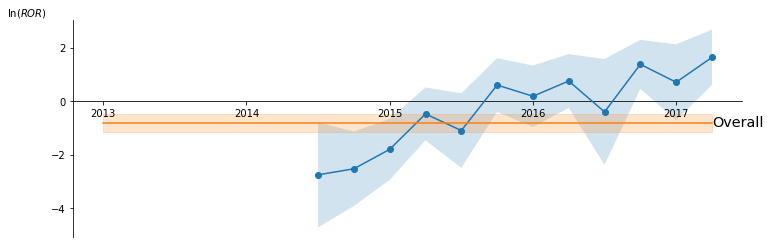

In [173]:
fig, ax = plt.subplots(figsize=(12, 4))
x = list(range(len(rors)))
ax.plot(x, rors.lROR, '-o', zorder=9)
ax.fill_between(x, np.log(rors.ce_from), np.log(rors.ce_to), alpha=0.2)
sns.despine()
ax.spines['bottom'].set_position('zero')
tks = []
lbls = []
for i, q in enumerate(rors.index):
    if q.endswith('q1'):
        tks.append(i)
        lbls.append(q.replace('q1', ''))
ax.set_xticks(tks)
ax.set_xticklabels(lbls)
ax.set_ylabel(r'$ \ln \left (ROR \right) $', rotation=0, ha='right', y=1)
ax.set_yticks([-4, -2, 0, 2, 4])

overall = ror_computations(contingency_table_from_results(res))
ror = overall['ROR']
se = overall['SE']
ce_from = np.exp(np.log(ror) - 1.96 * se)
ce_to = np.exp(np.log(ror) + 1.96 * se)
ax.plot(x, [np.log(ror)] * len(x), color='C1', zorder=9)
ax.fill_between(x, np.log(ce_from), np.log(ce_to), color='C1', alpha=0.2)
ax.text(max(x), np.log(ror), 'Overall', ha='left', va='center', fontsize='x-large')
None

In [159]:
ror

'ROR'

In [119]:
gr = res.groupby('q')
gr.apply?

In [ ]:
res.groupby('q').apply

In [107]:
tables.groupby

64

In [108]:
tables

is_drug  is_reaction       n
q                                     
2013q1 0    False        False  215932
       1    False         True    7246
2013q2 0    False        False  164943
       1    False         True    6404
2013q3 0    False        False  178529
       1    False         True    6994
       2     True        False       2
2013q4 0    False        False  226128
       1    False         True    5920
       2     True        False      28
2014q1 0    False        False  250778
       1    False         True    7423
       2     True        False      37
2014q2 0    False        False  195963
       1    False         True   24739
       2     True        False      74
2014q3 0    False        False  194803
       1    False         True   10483
       2     True        False     290
       3     True         True       1
2014q4 0    False        False  191615
       1    False         True    8473
       2     True        False     564
       3     True         True       2
2015q1 0    False        False  270111
       1    False         True   15869
       2     True        False     308
       3     True         True       3
2015q2 0    False        False  271347
       1    False         True    6610
...           ...          ...     ...
2015q3 2     True        False     319
       3     True         True       2
2015q4 0    False        False  288329
       1    False         True    6441
       2     True        False      98
       3     True         True       4
2016q1 0    False        False  336721
       1    False         True    7496
       2     True        False     112
       3     True         True       3
2016q2 0    False        False  286342
       1    False         True    6660
       2     True        False      81
       3     True         True       4
2016q3 0    False        False  274951
       1    False         True    6125
       2     True        False      67
       3     True         True       1
2016q4 0    False        False  269058
       1    False         True    5859
       2     True        False      58
       3     True         True       5
2017q1 0    False        False  310223
       1    False         True    6949
       2     True        False      44
       3     True         True       2
2017q2 0    False        False  292116
       1    False         True    5988
       2     True        False      38
       3     True         True       4

[64 rows x 3 columns]

In [49]:
lror = np.log(0.44)
lror

-0.8209805520698302

In [52]:
se = np.sqrt(np.sum(1 / contingecy_table.ravel()))

In [55]:
print(np.exp(lror), np.exp(1.96 * se))

0.44 1.3962116685617199


In [211]:
tbl_incidence = pd.read_csv('/Users/boris/devel/faers/data/interim/incidence/contingency_belviq.csv')
tbl_incidence.shape

(337695, 4)

In [212]:
tbl_incidence.outcome.sum()

7384

In [213]:
tbl_incidence.exposure.sum()

58

In [216]:
%run -i ../src/utils.py
gr = tbl_incidence.groupby('q')
matrices = []
for q, tbl in tqdm.tqdm(sorted(gr)):
    curr = ContingencyMatrix.from_results_table(tbl)
    curr.tbl['q'] = q
    if len(matrices):
        curr += matrices[-1]
    matrices.append(curr)

100%|██████████| 1/1 [00:00<00:00, 15.92it/s]


In [232]:
%run -i ../src/utils.py
contingency_matrices = pd.read_csv('/Users/boris/devel/faers/data/interim/contingency/contingency_belviq.csv')
gr = contingency_matrices.groupby('q')
for q, t in gr:
    t = ContingencyMatrix(t)
    break

In [233]:
t.ror(alpha=0.05)

(4.278376365441907, (4.1647288190949325, 4.395125137667375))

In [217]:
matrices

[Contingency matrix
                        n       q
 exposure outcome                
 False    False    330259  2017q2
          True       7378  2017q2
 True     False        52  2017q2
          True          6  2017q2]

In [215]:
pd.concat([m.tbl for m in matrices]).reset_index().set_index('q').sort_index()

,exposure,outcome,n
q,,,
2017q2,False,False,330259
2017q2,False,True,7378
2017q2,True,False,52
2017q2,True,True,6


In [202]:
matrices[0]

('2013q1', Contingency matrix
                        n       q
 exposure outcome                
 False    False    223178  2013q1
          True          0  2013q1
 True     False         0  2013q1
          True          0  2013q1)

In [194]:
z = matrices[-1][1] 
z

Contingency matrix
                       n
exposure outcome        
False    False    394525
         True          0
True     False         0
         True          0

In [195]:
curr

Contingency matrix
                       n
exposure outcome        
False    False    171347
         True          0
True     False         0
         True          0

In [196]:
z + curr

Contingency matrix
                       n
exposure outcome        
False    False    565872
         True          0
True     False         0
         True          0

In [178]:

gr = tbl_incidence.groupby('q')
for q, t in gr:
    break
print(t.head())
ContingencyMatrix.from_results_table(t)

        caseid  exposure  outcome       q
98692  4208366     False    False  2013q1
98702  5957578     False    False  2013q1
98727  6409598     False    False  2013q1
98730  6432595     False    False  2013q1
98731  6477605     False    False  2013q1


Contingency matrix
                       n
exposure outcome        
False    False    223178
         True          0
True     False         0
         True          0

In [170]:
t

,primaryid_x,caseid,drugname,primaryid_y,pt,q,config_drug,config_reaction
caseid,,,,,,,,
3037529,30375293,3037529,AVONEX,30375293,AMENORRHOEA,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,ASTHENIA,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,BLADDER DISORDER,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,BLOOD PRESSURE INCREASED,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,DEHYDRATION,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,DEPRESSION,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,DRY MOUTH,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,ESCHERICHIA SEPSIS,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."
3037529,30375293,3037529,AVONEX,30375293,HEPATIC FAILURE,2013q1,"(LORCASERIN, BELVIQ XR, AVONEX, BELVIQ)","(MITRAL VALVE INCOMPETENCE, AORTIC VALVE REPLA..."


In [163]:
tbl_incidence.head()

,caseid,exposure,outcome,q
0,10003318,False,False,2014q2
1,10003343,False,False,2014q1
2,10003397,False,False,2014q2
3,10003413,False,False,2014q1
4,10003421,False,False,2014q1
